In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import clmm.polaraveraging as pa
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import fnmatch
from scipy.integrate import quad
import pickle 

import iminuit
from iminuit import Minuit

In [2]:
%load_ext autoreload

%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')

import statistics_ as stat
import modeling as model
#import modeling_test as model
import utils as ut
import make_MetaCatalog as metacat
import make_binned_profile as prf
import resampling
from scipy import interpolate

sys.path.append('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Analysis/cosmoDC2/Fit_Halo_Mass/Fit_Cluster_Lensing_Mass/Run_Python_Codes')

import settings_analysis as settings

In [10]:
################################################################################################
cosmo = settings.cosmo

Richness_bin, Mass_bin, Z_bin = settings.Richness_bin, [[1.0*1e14, 1.01*1e14]], [[0.3,0.4]]

Choose_binning = 'M_fof'

is_deltasigma = True

################################################################################################
Mass_def = 'mean'

#signal = model.Signal(cosmo = cosmo)
#signal._set_halo_def(mass_def = Mass_def, delta_mdef = 200, halo_profile_model = 'einasto')
#signal._set_is_deltasigma(is_deltasigma = True)
#signal.available_parameters()
#signal._set_free_parameters(free_logm = True, free_concentration = True)
##############################################################################################

where_catalogs =settings.path_cosmoDC2
where_catalogs = '/sps/lsst/users/cpayerne/cosmoDC2_v1.1.4_image'

if Choose_binning == 'M_fof': Binning_your_data = Mass_bin
elif Choose_binning == 'richness': Binning_your_data = Richness_bin

In [11]:
os.chdir('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Analysis/cosmoDC2/cosmoDC2_details')
infos_cosmodc2 = 'infos_dc2.pkl'
with open(infos_cosmodc2, 'rb') as infos_cosmodc2:
    infos_dc2 = pickle.load(infos_cosmodc2)

## Defining Stacked cluster catalog

In [12]:
z_bin, obs_bin = Z_bin[0], Binning_your_data[0]
cat = metacat.MetaCatalog(is_deltasigma = True, cosmo = cosmo)

In [14]:
try : 
    
    up = (0.3*np.pi/180)*cosmo.eval_da(np.mean(z_bin))
    print(up)
                                       
    cat._check_available_catalogs(dc2_infos = infos_dc2, bin_def = Choose_binning, 
                                    z_bin = z_bin, 
                                    obs_bin = obs_bin, 
                                    where_source = where_catalogs, 
                                    r_lim = up)
    cat._check_average_inputs(dc2_infos = infos_dc2)

except ValueError: 
    

    print('impossible')

5.306971357260072
n = there are 7 available catalogs


In [254]:
cat.make_GalaxyCluster_catalog(shape_component1 = 'shear1', shape_component2 = 'shear2', tan_component = 'et', cross_component = 'ex')
cl = cat.cl

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [255]:
cl

GalaxyCluster Stack: (ra=0.0, dec=0.0) at z=nan
> 4030635 source galaxies
> With columns: r et ex z dc2_galaxy_id halo_id sigma_c <sigma_c-1>_v1 z_odds_photoz_v1 <sigma_c-1>_flexzboost_v1 z_odds_photoz_flexzboost_v1

In [256]:
cl = cat.compute_signal(photoz = False, catalog = cl)
cl = cat.compute_weights(photoz = False, catalog = cl)

In [257]:
cl = cat.compute_signal(photoz = 'BPZ', catalog = cl)
cl = cat.compute_weights(photoz = 'BPZ', catalog = cl)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_MetaCatalog.py:232: RuntimeWarning: divide by zero encountered in reciprocal
  catalog.galcat['st_v1'] = catalog.galcat['<sigma_c-1>_v1']**(-1.)*catalog.galcat['et']
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_MetaCatalog.py:233: RuntimeWarning: divide by zero encountered in reciprocal
  catalog.galcat['sx_v1'] = catalog.galcat['<sigma_c-1>_v1']**(-1.)*catalog.galcat['ex']


In [258]:
cl = cat.compute_signal(photoz = 'fleXZboost', catalog = cl)
cl = cat.compute_weights(photoz = 'fleXZboost', catalog = cl)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_MetaCatalog.py:237: RuntimeWarning: divide by zero encountered in reciprocal
  def compute_weights(self, photoz = 1, catalog = 1):
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_MetaCatalog.py:238: RuntimeWarning: divide by zero encountered in reciprocal
  


In [259]:

plt.figure(figsize=(7,7))
maskup = cl.galcat['z_odds_photoz_v1'] > 0.9
maskdown = cl.galcat['z_odds_photoz_v1'] < 0.9


plt.plot(cl.galcat['w_ls_true'][maskdown],cl.galcat['w_ls_v1'][maskdown], '.' ,label = 'BPZ odds < 0.9', markersize = 0.8)
plt.plot(cl.galcat['w_ls_true'][maskup],cl.galcat['w_ls_v1'][maskup], '.', label = 'BPZ odds > 0.9', markersize = 0.8)
plt.plot(cl.galcat['w_ls_true'],cl.galcat['w_ls_flexzboost_v1'], '.', label = 'flexZBoost', markersize = 0.8)
plt.plot(cl.galcat['w_ls_true'],cl.galcat['w_ls_true'], '-k', markersize = 0.8, label='x = y')

plt.ylabel(r'$w_{ls} (photoz)$', fontsize = 15)
plt.xlabel(r'$w_{ls} (true)$', fontsize = 15)
plt.legend()
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/compute_weight_v1.png', dpi = 300)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


KeyboardInterrupt: 

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fb5e3e80560> (for post_execute):


KeyboardInterrupt: 

In [260]:
cl

GalaxyCluster Stack: (ra=0.0, dec=0.0) at z=nan
> 4030635 source galaxies
> With columns: r et ex z dc2_galaxy_id halo_id sigma_c <sigma_c-1>_v1 z_odds_photoz_v1 <sigma_c-1>_flexzboost_v1 z_odds_photoz_flexzboost_v1 st_true sx_true w_ls_true st_v1 sx_v1 w_ls_v1 st_flexzboost_v1 sx_flexzboost_v1 w_ls_flexzboost_v1

In [261]:
mask = (cl.galcat['w_ls_v1'] != 0)*(cl.galcat['w_ls_flexzboost_v1'] != 0)
cl_cut = cl.galcat[mask]
cl_cut = clmm.GalaxyCluster('Stack', 0, 0, cl.z, cl_cut)
cl_cut.n_stacked_catalogs = cl.n_stacked_catalogs

In [262]:
down, up, n_bins = 0.2 , (0.3*np.pi/180)*cosmo.eval_da(cat.z)-0.5 , 50

In [263]:
bin_edges = pa.make_bins( down , up , n_bins , method = 'evenwidth')
shear = prf.Shear(is_deltasigma = True, cosmo = cosmo)
profile_true = shear.make_binned_profile(metacatalog = cl_cut, tan = 'st_true', cross = 'sx_true', weights = 'w_ls_true', bin_edges = bin_edges)
profile_photoz_v1 = shear.make_binned_profile(metacatalog = cl_cut, tan = 'st_v1', cross = 'sx_v1', weights = 'w_ls_v1', bin_edges = bin_edges)
profile_photoz_flexzboost_v1 = shear.make_binned_profile(metacatalog = cl_cut, tan = 'st_flexzboost_v1', cross = 'sx_flexzboost_v1', weights = 'w_ls_flexzboost_v1', bin_edges = bin_edges)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_binned_profile.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  profile['gal_id'] = np.array(gal_id)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_binned_profile.py:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  profile['halo_id'] = np.array(halo_id)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/make_binned_profile.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

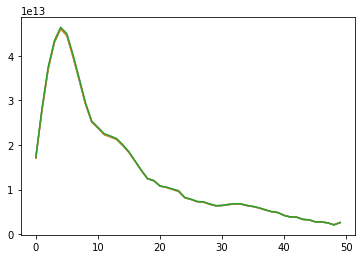

In [264]:
plt.plot(profile_photoz_flexzboost_v1['gt'])
plt.plot(profile_true['gt'])
plt.plot(profile_photoz_v1['gt'])

In [267]:
bais_v1 = -(profile_photoz_v1['gt'] - profile_true['gt'])/profile_true['gt']
bais_flexzboost_v1 = -(profile_photoz_flexzboost_v1['gt'] - profile_true['gt'])/profile_true['gt']

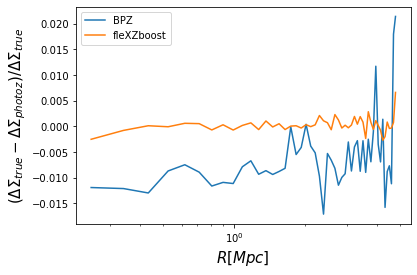

In [269]:
plt.plot(profile_true['radius'], bais_v1, label='BPZ')
plt.plot(profile_true['radius'], bais_flexzboost_v1, label='fleXZboost')
plt.xscale('log')
plt.xlabel(r'$R [Mpc]$', fontsize = 15)
plt.ylabel(r'$(\Delta\Sigma_{true} - \Delta\Sigma_{photoz})/\Delta\Sigma_{true}$', fontsize = 15)
plt.legend()
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/diff_photoz.png', dpi = 300)

In [ ]:
def bootstrap_resampling_numpy(binned_profile = 1, metacatalog = 1, n_boot = 1):
        
        """
        Method:
        ------
        Calculates the bootstrap covariance matrix from true shear measurements
        Attributes:
        ----------
        binned_profile : Astropy Table
            Table containing meta data and binned profile
        catalog : GalaxyCluster catalog
            meta data catalog
        n_boot : int
            the number of bootstrap resampling
        Returns:
        -------
        cov_t_boot, cov_x_boot : array, array
            the covariance matrices respectively for tangential and cross shear
        """
        
        profile = binned_profile
        
        names = []
        
        for i, r in enumerate(profile):
            
            names.append('x' + str(i))
        
        t,x = Table(names = names), Table(names = names)

        indexes = np.arange(cl_cut.n_stacked_catalogs)

        for n in range(n_boot):

            choice_halo_id = np.array(np.random.choice(indexes, metacatalog.n_stacked_catalogs))
   
            unique_halo_id, n_repeated = np.unique(choice_halo_id, return_counts = True)

            signal_t, signal_x = [], []

            index = np.argsort(unique_halo_id)

            unique_id = unique_halo_id[index]

            repetition = n_repeated[index]

            f = interpolate.interp1d(unique_id, repetition)

            for i, r in enumerate(profile['radius']):

                mask = np.isin(profile['halo_id'][i], unique_halo_id)

                halo_id = np.array(profile['halo_id'][i][mask])

                et, ex = profile['et'][i][mask], profile['ex'][i][mask]

                r = f(halo_id)

                wls = profile['w_ls'][i][mask] * r

                signal_t.append(np.sum(et*wls)/np.sum(wls))

                signal_x.append(np.sum(ex*wls)/np.sum(wls))

            t.add_row(signal_t), x.add_row(signal_x)
            
        listet, listex = [], []
        
        for n in names:
            
            listet.append(t[n]), listex.append(x[n])
            
        Xt, Xx = np.stack((listet), axis=0), np.stack((listex), axis=0)
        
        covt, covx = np.cov(Xt), np.cov(Xx)
        
        return covt, covx
            

# Estimating individual profile

In [31]:
#p_individual_t = []
#p_individual_x = []
#for i in range(cl.n_stacked_catalogs):
#    cl_individual = cat.list_cl[i]
#    cat.add_weights(cl_individual)
#    profile_ = shear.make_binned_profile(metacatalog = cl_individual, bin_edges = bin_edges)
#    p_individual_t.append([profile_['radius'],profile_['gt']])
#    p_individual_x.append([profile_['radius'],profile_['gx']])

In [32]:
#plt.plot(profile['radius'],profile['gt']/np.sqrt(cov_t_sample.diagonal()), 'k')
#plt.xlim(profile['radius'][0], profile['radius'][-1])
#plt.xscale('log')
#plt.ylabel(r'$S/N$')
#plt.xlabel('R [Mpc]')
#plt.legend(frameon = False)
#os.chdir('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3')
#plt.savefig('sample_cov.png', bbox_inches='tight', dpi=300)

# Estimating Bootstrap covariance matrix

In [33]:
cov_t = cov_t_boot
cov_x = cov_x_boot

In [34]:
profile['gt_err'] = np.sqrt(cov_t.diagonal())
profile['gx_err'] = np.sqrt(cov_x.diagonal())

<ErrorbarContainer object of 3 artists>

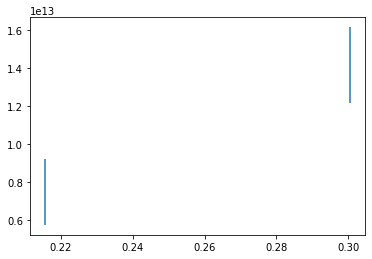

In [35]:
plt.errorbar(profile['radius'], profile['gt'], profile['gt_err'])

# DEFINNING MODEL

In [191]:
cluster_z = cat.z
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo)


In [192]:
#def predict_excess_surface_density(r, logm):
    
#    c = model.Duffy_concentration(10.**logm, cluster_z, 'mean')

#    m = 10.**logm 
    
#    moo.set_mass(m) 
    
#    moo.set_concentration(c)
    
#    deltasigma = []
    
#    for i, R in enumerate(r):
        
#        surface_density = moo.eval_sigma_excess(R, cluster_z)
    
#        deltasigma.append(surface_density)
        
#    return deltasigma


In [193]:
r_lim = max(0.5*cluster_z + 0.50, down)
r_up = 4

index = np.arange(len(profile['radius']))

mask_down = (profile['radius'] > r_lim) 
mask_up = (profile['radius'] < r_up)

mask = mask_down*mask_up

index_mask = index[mask]

R = profile['radius'][mask]

y_exp = profile['gt'][mask]

n = len(mask[mask == True])

In [194]:
cov_fit = np.zeros((n,n))
for i in range(n):
    index_1 = index_mask[i]
    for j in range(n):
        index_2 = index_mask[j]
        cov_fit[i,j] = cov_t[index_1, index_2]

In [195]:

#plt.plot(R,np.sqrt(cov_fit.diagonal()),'k')
#plt.plot(profile['radius'],np.sqrt(cov_t_bootstrap.diagonal()),'--g')

In [196]:
bins = np.array([[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges) - 1)])
mask = profile['radius'] > r_lim
bins = bins[mask]

In [197]:
def predict_excess_surface_density(r, logm):
    
    c = model.Duffy_concentration(10.**logm, cluster_z, 'mean')

    m = 10.**logm 
    
    moo.set_mass(m) 
    
    moo.set_concentration(c)
    
    deltasigma = []
    
    for i, R in enumerate(r):
    
        deltasigma.append(moo.eval_sigma_excess(R, cluster_z))
        
    return np.array(deltasigma)

In [198]:
def chi2(logm):
    
    chi2 = 0
    
    inv_cov = np.linalg.inv(np.diag(np.diag(cov_fit)))
    
    y_predict = predict_excess_surface_density(R, logm)
    
    for i, r in enumerate(R):
        
        for j, rprime, in enumerate(R):
            
            chi2 += (y_predict[i] - y_exp[i])*inv_cov[i,j]*(y_predict[j] - y_exp[j])

    return chi2

In [199]:
#m = Minuit.from_array_func(chi2, (13,1,0.1), errordef = 0.5)

m = Minuit(chi2, logm = 13, limit_logm = (11,16), errordef = 1)

m.migrad()

m.hesse()

m.minos()

chi2min_dof =  m.fval/(n_bins-1)

print(m.params)


┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ logm │  14.124   │   0.009   │   -0.009   │   0.009    │   11    │   16    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [200]:
m.fval/(len(R)-1)


1.257527516963796

In [201]:
model.Duffy_concentration(10**m.values['logm'], cluster_z, 'mean')

5.465444812863793

In [202]:
mass = 10**m.values['logm']

In [203]:
err_mass = np.log(10)*mass*(m.errors['logm'])

In [204]:
print(f'{mass:.2e} pm {err_mass:.2e}')

1.33e+14 pm 2.70e+12


In [205]:
def myyticks(x,pos):
    if x == 0: return "$0$"

    sign = x/abs(x)
    coeff = (x)/10**13

    return r"${:2.1f}$".format(coeff)

def myxticks(x,pos):
    if x == 0: return "$0$"

    exponent = int(np.log10(abs(x)))
    sign = x/abs(x)
    coeff = (x/(10**exponent))

    
    return r"${:.1f}$".format(x)

In [206]:
rr = np.linspace(0.1,10,100)
gt, gt_err = profile['gt'], profile['gt_err']
gx, gx_err = profile['gx'], profile['gx_err']
#y_up = predict_excess_surface_density(R, m.values['logm'] + 3*m.merrors['logm'].upper, m.values['c'] + 3*m.merrors['c'].upper)
#y_down = predict_excess_surface_density(R, m.values['logm'] + 3*m.merrors['logm'].lower,  m.values['c'] + 3*m.merrors['c'].lower)
y = predict_excess_surface_density(R, m.values['logm'])

In [32]:
y_up = []
y_down = []

for i, r_ in enumerate(R):
    
    def shear(p): 
        
        return predict_excess_surface_density([r_], p[0], p[1])[0]
    
    def shear_(p): return -shear(p)
    
    bounds = [(m.values['logm'] - 1*m.errors['logm'],m.values['logm'] + 3*m.errors['logm']),
              (m.values['c'] - 1*m.errors['c'],m.values['c'] + 3*m.errors['c'])]

    from scipy.optimize import fmin_tnc

    logm_min, c_min = fmin_tnc(shear, np.array([m.values['logm'],m.values['c']]), approx_grad = True, bounds = bounds)[0]
    logm_max, c_max = fmin_tnc(shear_, np.array([m.values['logm'],m.values['c']]), approx_grad = True, bounds = bounds)[0]
    
    y_up.append(shear([logm_max, c_max]))
    y_down.append(shear([logm_min, c_min]))
    
    

KeyError: 'c'

In [207]:
y_up = predict_excess_surface_density(R, m.values['logm'] + 3*m.errors['logm'])
y_down = predict_excess_surface_density(R, m.values['logm'] - 3*m.errors['logm'])

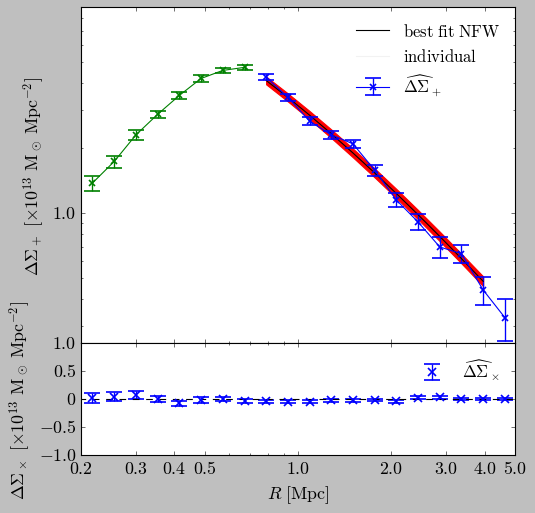

In [209]:
from matplotlib import gridspec
import matplotlib.ticker as ticker
plt.style.use('classic')

ylabelup = r'$\Delta\Sigma_+$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
ylabeldown = r'$\Delta\Sigma_\times$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
xlabel = r'$R\ [$' + r'${\rm Mpc}$' + r'$]$'

# Simple data to display in various forms

fig = plt.figure(figsize = (7,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.set_ylabel(ylabelup, fontsize=16)
#ax0.set_ylabel('r'$\rm{stacked}\ \Delta\Sigma_\times$)

# log scale for axis Y of the first subplot
ax0.set_yscale("log")
ax0.set_xscale("log")
#ax0.set_xlim(down, up)
ax0.set_ylim(2.5*10**12, 9*10**13)

ax0.fill_between(R, y_up , y_down ,color = 'r', alpha = 1)
ax0.plot(R,y ,'-k', alpha = 1, label=r'$\rm{best\ fit\ NFW}$')
line0 = ax0.errorbar(profile['radius'][profile['radius']>r_lim], gt[profile['radius']>r_lim],gt_err[profile['radius']>r_lim],fmt='-x',capsize = 7 ,ecolor = 'b',elinewidth=1.2, c='b',
                     markeredgecolor='b',markerfacecolor='None',markeredgewidth=1.5,label=r'$\widehat{\Delta\Sigma}_+$')
line0 = ax0.errorbar(profile['radius'][profile['radius']<r_lim], gt[profile['radius']<r_lim],gt_err[profile['radius']<r_lim],fmt='-x',capsize = 7 ,ecolor = 'g',elinewidth=1.2, c='g',
                     markeredgecolor='g',markeredgewidth=1.5,markerfacecolor='None')

ax0.plot([],[], c='grey', alpha = 0.1,label=r'$\rm{individual}$')

#for p_ in p_individual_t:
    
#    ax0.plot(p_[0],p_[1],'-',c='grey',alpha=0.1,zorder = 0)

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(myyticks))
ax0.legend(loc='best', frameon = False,
          numpoints = 1, fontsize = 15)

##############################
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlabel(xlabel, fontsize=16)
ax1.set_ylabel(ylabeldown, fontsize=16)

line1 = ax1.errorbar(profile['radius'], gx,gx_err, label=r'$\widehat{\Delta\Sigma}_\times$'\
                    ,fmt='x',capsize = 7 ,ecolor = 'b',elinewidth=1.2, c='b',\
                 markeredgecolor='b',markerfacecolor='None',markeredgewidth=1.5, markersize = 8)


ax1.plot(rr, 0*rr, '--k')
ax1.legend(loc='upper right', frameon = False,
          numpoints = 1, fontsize = 15)

#for p_ in p_individual_x:
    
#    ax1.plot(p_[0],p_[1],'-',c='grey',alpha=0.1,zorder = 0)
 

plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot

yticks = ax1.yaxis.get_major_ticks()
ax1.set_xticks([0.2,0.3,0.4,0.5,1,2,3,4,5])
yticks[-1].label1.set_visible(False)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(myyticks))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(myxticks))
ax1.set_xlim(down, up)
ax1.set_ylim(-1*10**13, 1*10**13)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)

plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/DeltaSigma_Stacking.png', bbox_inches='tight', dpi=300)

plt.show()